['military uniform']
['flat-coated retriever' 'tabby' 'Persian cat' 'Egyptian cat'
 'Staffordshire bullterrier' 'American Staffordshire terrier'
 'Persian cat' 'Egyptian cat' 'papillon' 'Scottish deerhound' 'kelpie'
 'chow' 'lynx' 'tabby' 'Walker hound' 'schipperke' 'briard' 'bull mastiff'
 'schipperke' 'tabby' 'Angora' 'flat-coated retriever'
 'Labrador retriever' 'Border collie' 'Persian cat'
 'Chesapeake Bay retriever' 'tabby' 'Rhodesian ridgeback' 'tabby' 'tabby'
 'tabby' 'schipperke']
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_15 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dense_6 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
______

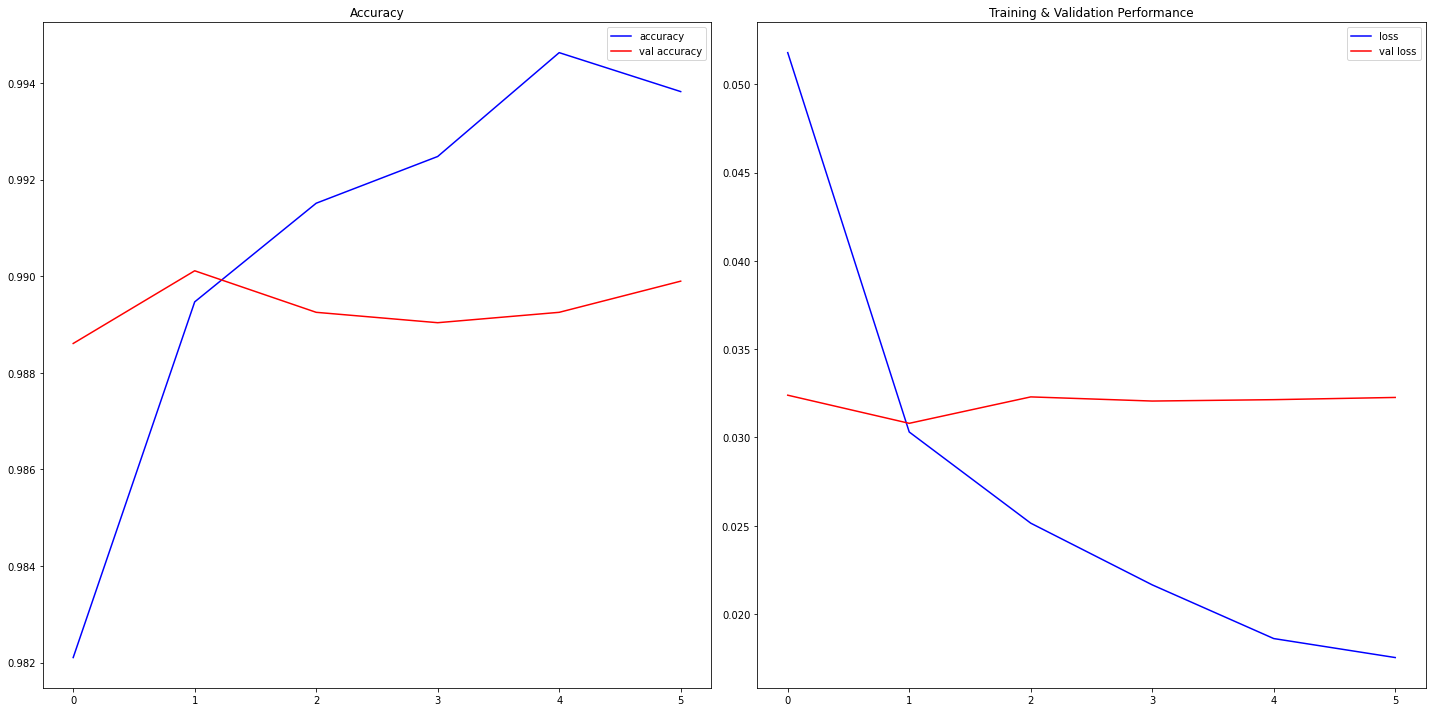

['cat' 'dog']
1/1 - 0s - 442ms/epoch - 442ms/step
[1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0]
['dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog'
 'cat' 'cat' 'dog' 'cat' 'dog' 'dog' 'dog' 'cat' 'cat' 'dog' 'dog' 'dog'
 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat']


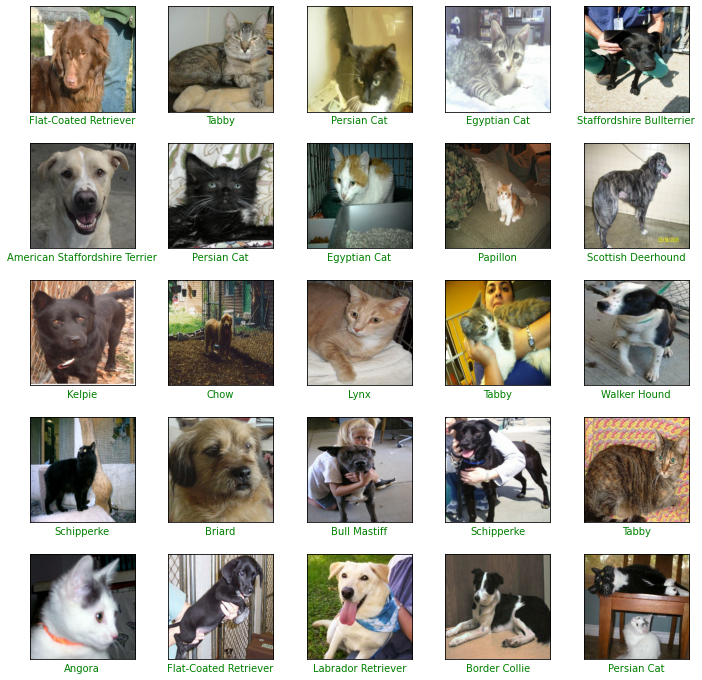

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf
import PIL.Image as Image
import os
from os.path import join, dirname
_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
RES=224
# MobileNet expects 224x224x3

model = tf.keras.Sequential([
    hub.KerasLayer(_URL, input_shape=(RES, RES, 3))
])
#model.summary()
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((RES, RES))


grace_hopper=np.array(grace_hopper)/255.0
grace_hopper.shape

result=model.predict(grace_hopper[np.newaxis, ...])

result=np.argmax(result, axis=-1)

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

print(imagenet_labels[result])

(train_data, val_data), meta = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]']
)

normalize= lambda x, y: (tf.image.resize(x, (RES,RES))/255.0, y)
num_train=meta.splits['train'].num_examples

BATCH=32

train_batches=train_data.shuffle(num_train//4).map(normalize).batch(BATCH).prefetch(1)
val_batches=val_data.map(normalize).batch(BATCH).prefetch(1) 

image_batch, labels_batch = next(iter(train_batches.take(1)))
image_batch, labels_batch = image_batch.numpy(), labels_batch.numpy()

resultant = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(resultant, axis=-1)]
print(predicted_class_names)

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(RES,RES,3))
feature_extractor.trainable=False

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2, activation='softmax', kernel_initializer='he_normal')
])
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

EPOCHS=6
hist = model.fit(train_batches,
    epochs=EPOCHS,
    validation_data=val_batches)

def summarize_model_diagnostics(history):
    loss, acc = history.history['loss'], history.history['accuracy']
    val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy']
    fig, ax=plt.subplots(1,2, figsize=(20,10))
    ax[1].plot(range(EPOCHS), loss, label='loss',color='blue')
    ax[1].plot(range(EPOCHS), val_loss, label='val loss', color='r')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Loss')

    ax[0].plot(range(EPOCHS), acc, label='accuracy',color='blue')
    ax[0].plot(range(EPOCHS), val_acc, label='val accuracy', color='r')
    ax[0].legend(loc='upper right')
    ax[0].set_title('Accuracy')
    plt.title('Training & Validation Performance')
    plt.tight_layout()
    plt.show()

summarize_model_diagnostics(history=hist)

class_names = np.array(meta.features['label'].names)
print(class_names)

predicts=model.predict(image_batch, verbose=2)
predicts_batch = tf.squeeze(predicts).numpy()
predicted_labels = np.argmax(predicts_batch, axis=-1)
predicted_labels_names = class_names[predicted_labels]

print(labels_batch)
print(predicted_labels_names)

def plot_predicts():
    plt.figure(figsize=(12,12))
    for i in range(25):
      plt.subplot(5,5, i+1)
      #plt.subplots_adjust(hspace=0.3)
      plt.imshow(image_batch[i])
      color = 'green' if predicted_labels[i] == labels_batch[i] else 'red'
      plt.xlabel(str(predicted_class_names[i].title()), color=color)
      plt.xticks([])
      plt.yticks([])
      plt.subplots_adjust(hspace=0.3)
    #plt.tight_layout()
    plt.show()




plot_predicts()